In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import mlflow
# from mlflow.models import infer_signature

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Others
import os
from tqdm import tqdm

# Set float format for pandas
pd.set_option('display.float_format', lambda x: '%.4f' % x)

np.random.seed(42)  # This sets the seed for numpy's random number generator

## Reading data

In [3]:
training_data   = pd.read_csv("../data/processed/training_data.csv").drop(columns = ["geometry"])
validation_data = pd.read_csv("../data/processed/validation_data.csv")

## Analyse data

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm

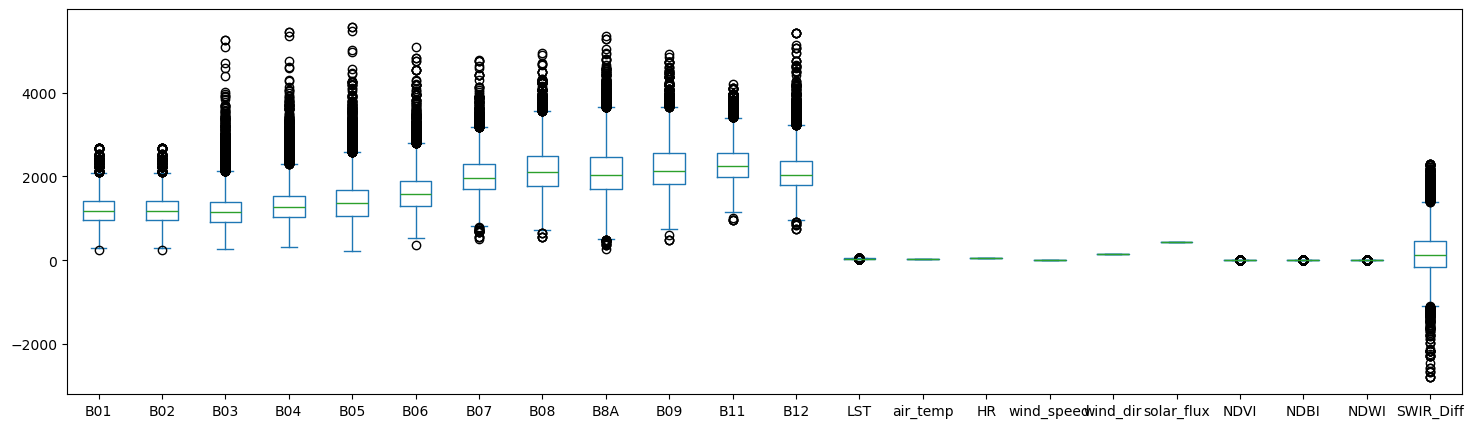

In [5]:
drop_columns = ["Longitude", "Latitude", "UHI Index", "datetime"]
training_data_drop = training_data.drop(columns = drop_columns)
fig, ax = plt.subplots(figsize = (18,5))
_ = training_data_drop.plot(kind="box", ax=ax)

In [6]:
training_data_drop.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'LST', 'air_temp', 'HR', 'wind_speed', 'wind_dir',
       'solar_flux', 'NDVI', 'NDBI', 'NDWI', 'SWIR_Diff'],
      dtype='object')

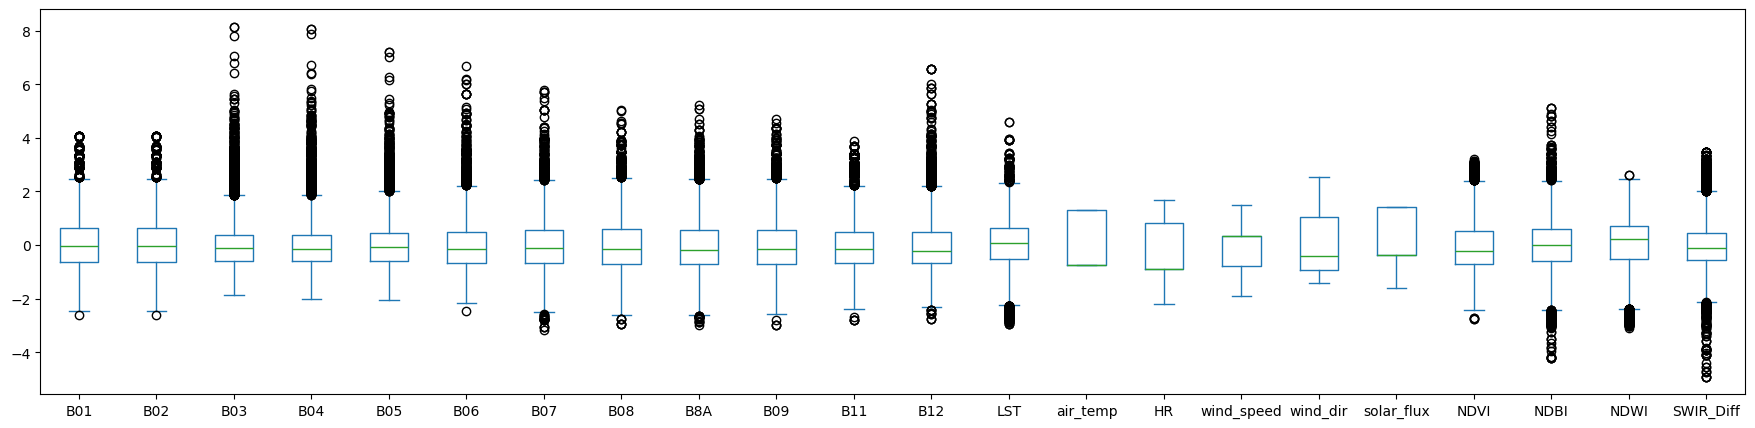

In [7]:
sc = StandardScaler()

training_data_drop_normalized = pd.DataFrame(sc.fit_transform(training_data_drop), columns = training_data_drop.columns)#.astype(np.float32)

fig, ax = plt.subplots(figsize = (22,5))
_ = training_data_drop_normalized.plot(kind="box", ax=ax)

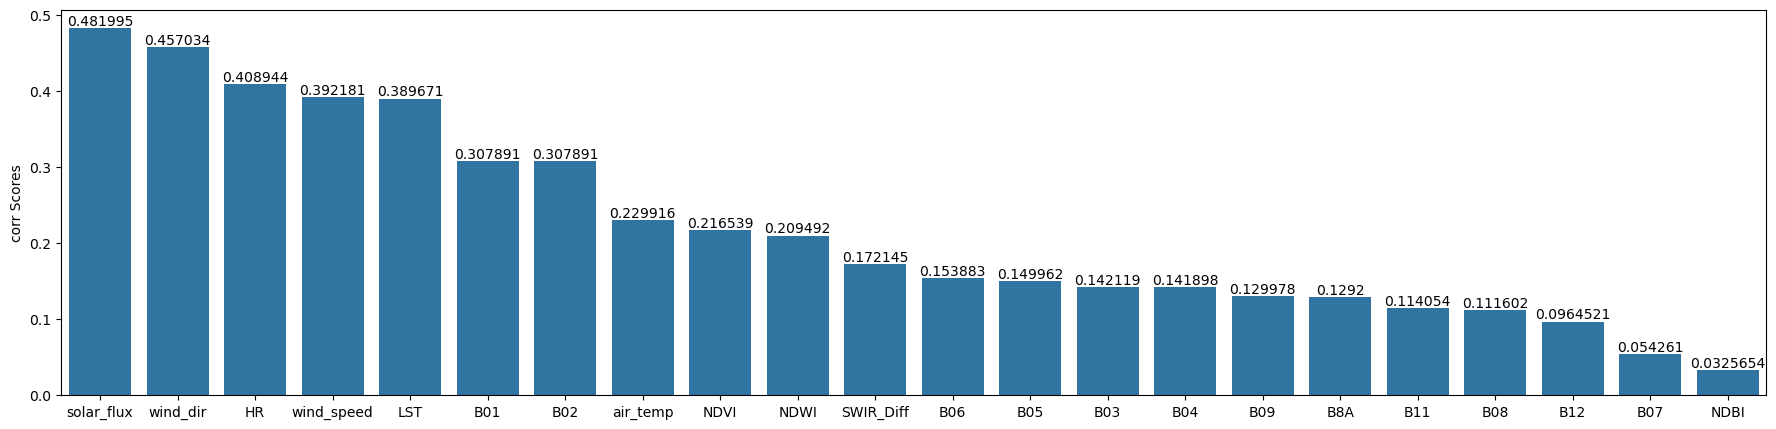

In [8]:
corr1=[]
# remove_columns = ['UHI Index', 'Latitude', 'Longitude', 'datetime']
for col in training_data_drop_normalized.columns:
    corr=abs(training_data['UHI Index'].corr(training_data_drop[col]))
    corr1.append(corr)

corr = pd.Series(corr1, name="corr Scores", index=training_data_drop_normalized.columns)
corr = corr.sort_values(ascending=False)
fig, ax = plt.subplots(figsize = (22, 5))
g = sns.barplot(corr, ax = ax)
_ = g.bar_label(ax.containers[0], fontsize=10)

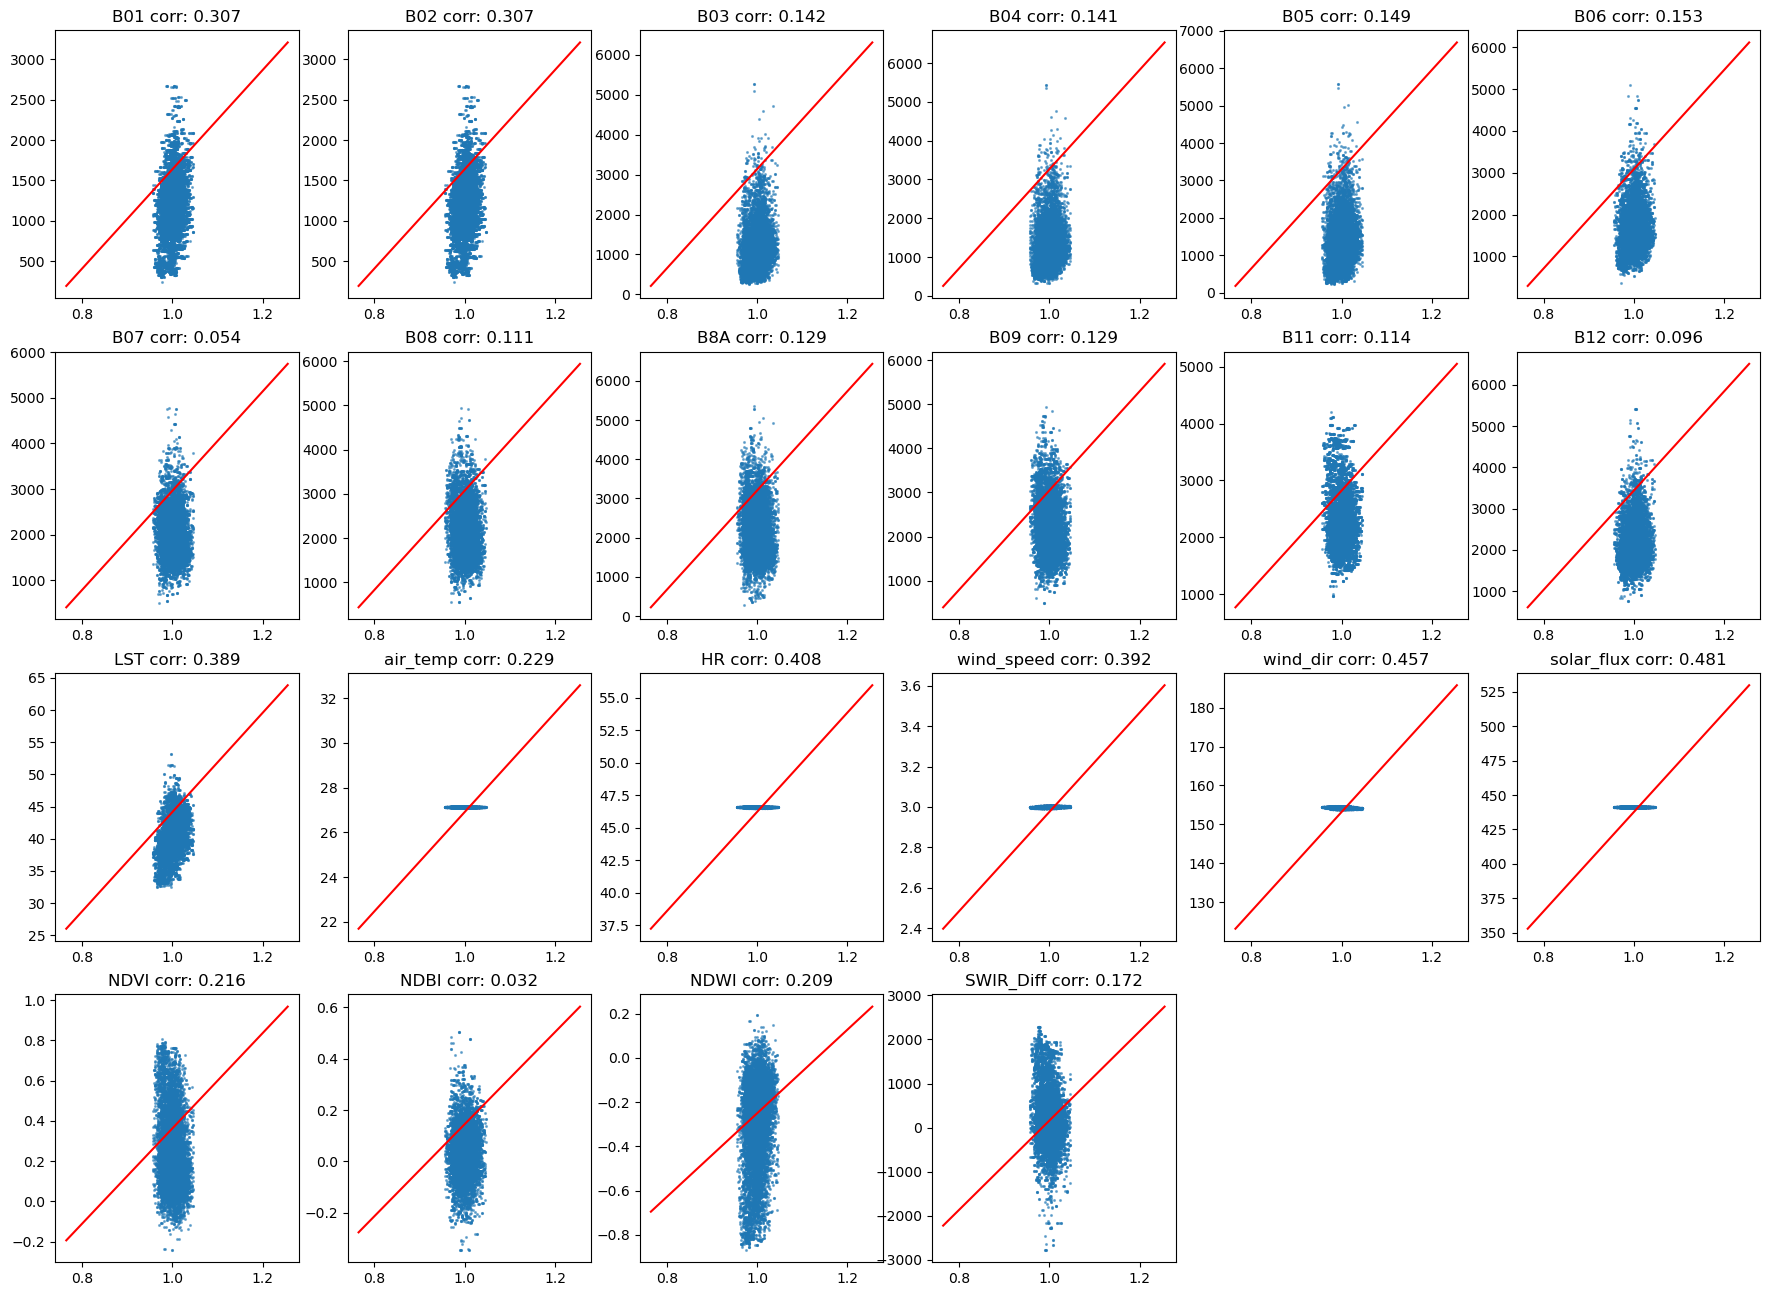

In [9]:
fig, ax = plt.subplots(4, 6, figsize=(22, 16))

axes = ax.flatten()
for i, col_name in enumerate(training_data_drop.columns):
    axes[i].scatter(
        training_data["UHI Index"],
        training_data_drop[col_name],
        label = col_name,
        s = 1.5,
        alpha = 0.5
    )
    axes[i].plot(
        [training_data["UHI Index"].min()*0.8, training_data["UHI Index"].max()*1.2],
        [training_data_drop[col_name].min()*0.8, training_data_drop[col_name].max()*1.2],
        "-r"
        )
    axes[i].set_title(col_name+" corr: "+str(corr[col_name])[:5])
    # axes[i].set_xlim(training_data["UHI Index"].min()*0.5, training_data["UHI Index"].max()*1.5)
    # axes[i].set_ylim(training_data_drop[col_name].min()*0.5, training_data_drop[col_name].max()*1.5)

for ax in axes.flatten():
    if not ax.has_data():
        ax.set_axis_off()

In [10]:
training_data.duplicated().value_counts()

False    11229
Name: count, dtype: int64

In [11]:
print(training_data_drop_normalized.columns)
training_data_drop_normalized.duplicated().value_counts()

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'LST', 'air_temp', 'HR', 'wind_speed', 'wind_dir',
       'solar_flux', 'NDVI', 'NDBI', 'NDWI', 'SWIR_Diff'],
      dtype='object')


False    9101
True     2128
Name: count, dtype: int64

In [34]:
# with drop_bands

related_bands = ["B03", "B04", "B08", "B11", "B12", 'air_temp', 'HR', 'wind_speed', 'wind_dir', 'solar_flux']
X_clean_data = sm.add_constant(training_data_drop_normalized)
X_clean_data = X_clean_data.drop(columns = related_bands)
y_clean_data = training_data["UHI Index"]

mod = sm.OLS(y_clean_data.reset_index(drop=True), X_clean_data.reset_index(drop=True))
res = mod.fit()
valid_cols = res.pvalues[res.pvalues < 0.05].index.to_list()[1:]

X_clean_data_dropped = X_clean_data[valid_cols]
# Print summary
print("Valid columns:", valid_cols)
print(res.summary())

Valid columns: ['B01', 'B02', 'B05', 'B07', 'B8A', 'LST', 'NDVI', 'NDWI', 'SWIR_Diff']
                            OLS Regression Results                            
Dep. Variable:              UHI Index   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     226.2
Date:                Fri, 28 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:26:28   Log-Likelihood:                 31460.
No. Observations:               11229   AIC:                        -6.290e+04
Df Residuals:                   11217   BIC:                        -6.281e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

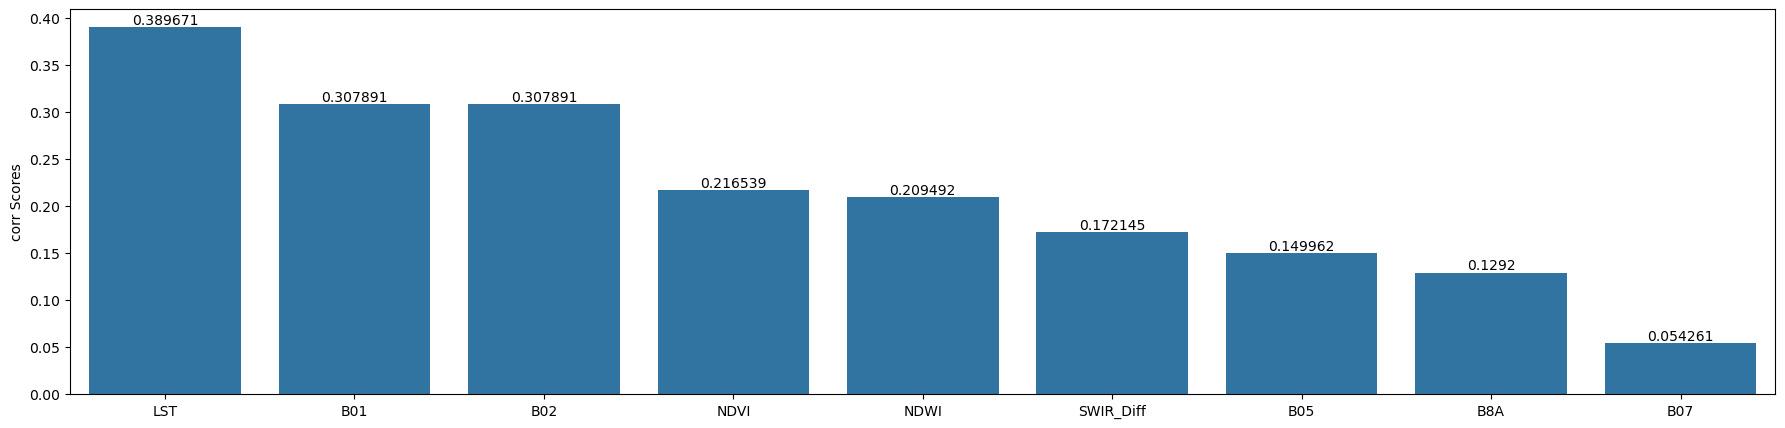

In [37]:
corr1=[]
# remove_columns = ['UHI Index', 'Latitude', 'Longitude', 'datetime']
for col in X_clean_data_dropped.columns:
    corr=abs(training_data['UHI Index'].corr(X_clean_data_dropped[col]))
    corr1.append(corr)

corr = pd.Series(corr1, name="corr Scores", index=X_clean_data_dropped.columns)
corr = corr.sort_values(ascending=False)

X_clean_data_dropped = X_clean_data_dropped[corr[corr>0.05].index.to_list()]

fig, ax = plt.subplots(figsize = (22, 5))
g = sns.barplot(corr, ax = ax)
_ = g.bar_label(ax.containers[0], fontsize=10)

In [38]:
from sklearn.covariance import EllipticEnvelope

# final_data_D = training_data_drop_normalized.drop(columns = drop_bands + related_bands + ["NDVI"])
# Fit an EllipticEnvelope model to the data
outlier_detector = EllipticEnvelope(contamination=0.1)
outlier_detector.fit(X_clean_data_dropped)

# Predict the outliers
outliers = outlier_detector.predict(X_clean_data_dropped) == -1
# related_bands = ["B03", "B04", "B08", "B11", "B12"]

# Remove the outliers from the dataset
X = training_data.loc[training_data_drop_normalized.index[~outliers], valid_cols]
y= training_data.loc[training_data_drop_normalized.index[~outliers],"UHI Index"]

print("Number of outliers detected:", np.sum(outliers))
print(training_data_drop_normalized.shape)
print(X_clean_data_dropped.shape)
print(X.shape)
print(y.shape)

Number of outliers detected: 1123
(11229, 22)
(11229, 9)
(10106, 9)
(10106,)


## Build Model

In [14]:
# Feature Engineering
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, cross_val_score

# Machine Learning
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, log_loss
import xgboost as xgb

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [39]:
print(X.describe())

             B01        B02        B05        B07        B8A        LST  \
count 10106.0000 10106.0000 10106.0000 10106.0000 10106.0000 10106.0000   
mean   1199.5101  1199.5101  1396.0235  1946.2656  2028.9470    40.8392   
std     321.7689   321.7689   458.3588   391.2440   492.2876     2.4808   
min     336.0000   336.0000   316.0000   682.0000   490.0000    32.5300   
25%     987.5000   987.5000  1106.0000  1672.0000  1671.0000    39.4000   
50%    1184.0000  1184.0000  1367.0000  1924.0000  1972.0000    40.9700   
75%    1406.0000  1406.0000  1648.7500  2194.0000  2344.0000    42.3800   
max    2518.0000  2518.0000  3104.0000  3352.0000  3588.0000    49.9400   

            NDVI       NDWI  SWIR_Diff  
count 10106.0000 10106.0000 10106.0000  
mean      0.2253    -0.2774   153.6161  
std       0.1505     0.1606   481.5073  
min      -0.2420    -0.8193 -1684.0000  
25%       0.1175    -0.3667  -144.0000  
50%       0.1965    -0.2449   115.0000  
75%       0.3120    -0.1636   404.000

In [40]:
print(y.describe())

count   10106.0000
mean        1.0005
std         0.0161
min         0.9561
25%         0.9894
50%         1.0006
75%         1.0115
max         1.0460
Name: UHI Index, dtype: float64


In [17]:
# best_model = RandomForestRegressor(n_estimators = 800, random_state=42).fit(X_train, y_train)
# y_pred = best_model.predict(X_test)
# print(r2_score(y_test, y_pred))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

# Define the hyperparameter grid XGBRFRegressor
# xgb_param_grid = {
#     'n_estimators': [700, 850, 1000],  # Ajustamos el rango para equilibrio entre complejidad y rendimiento
#     'max_depth': [4, 6, 8],  # Evitamos árboles demasiado profundos para no sobreajustar a la baja variabilidad de y
#     'learning_rate': [0.01, 0.03, 0.05],  # Tasa de aprendizaje baja para capturar pequeñas variaciones
#     'subsample': [0.8, 0.9, 1.0],  # Mantiene diversidad en los árboles sin perder generalización
#     'colsample_bytree': [0.7, 0.8, 0.9],  # Evita que el modelo dependa de todas las variables en cada árbol
#     'reg_lambda': [5, 10, 20],  # Regularización L2 más fuerte para controlar la variabilidad baja de y
#     'reg_alpha': [1, 5, 10],  # Regularización L1 para mayor estabilidad
# }
# Create an instance of the XGBRegressor
# model = xgb.XGBRFRegressor(random_state=42)

# # Define the hyperparameter grid RandomForestRegressor
# param_grid_rf = {
#     'n_estimators': [800, 1000],  # Número de árboles
#     'max_depth': [10, 20],         # Profundidad máxima de los árboles
#     'min_samples_split': [2, 5],   # Mínimo de muestras para dividir un nodo
#     'min_samples_leaf': [1, 2],    # Mínimo de muestras por hoja
# }
# # Create an instance of the RandomForestRegressor
# model = RandomForestRegressor(random_state=42)

# param_grid_gbr = {
#     'n_estimators': [200, 300],      # Número de árboles
#     'learning_rate': [0.05, 0.1],    # Tasa de aprendizaje
#     'max_depth': [3, 5],             # Profundidad máxima de los árboles
# }
# model = GradientBoostingRegressor(random_state=42)

param_grid_etr = {
    'n_estimators': [800, 1000],  # Número de árboles
    'max_depth': [10, 20],         # Profundidad máxima de los árboles
    'min_samples_split': [2, 5],   # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2],    # Mínimo de muestras por hoja
}
model = ExtraTreesRegressor(random_state=42)

# param_grid_catboost = {
#     'iterations': [500, 1000],     # Número de árboles
#     'learning_rate': [0.05, 0.1],  # Tasa de aprendizaje
#     'depth': [6, 10],              # Profundidad de los árboles
# }
# model = CatBoostRegressor(random_state=42, verbose=0)

# param_grid_hgb = {
#     'learning_rate': [0.05, 0.1],   # Tasa de aprendizaje
#     'max_iter': [300, 500],         # Iteraciones (equivalente a n_estimators)
#     'max_depth': [10, 20],          # Profundidad máxima
# }
# model = HistGradientBoostingRegressor(random_state=42)

# param_grid_lgbm = {
#     'n_estimators': [300, 500],     # Número de árboles
#     'learning_rate': [0.05, 0.1],   # Tasa de aprendizaje
#     'num_leaves': [31, 50],         # Controla la complejidad del modelo
# }
# model = LGBMRegressor(random_state=42)

# param_grid_mlp = {
#     'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)],  # Número de neuronas por capa
#     'activation': ['relu'],  # Función de activación
#     'alpha': [0.0001, 0.001],  # Regularización L2
#     'learning_rate_init': [0.001, 0.01],  # Tasa de aprendizaje
# }

# model = MLPRegressor(random_state=42, max_iter=1000)

# Create an instance of the KFold class
# kf = KFold(n_splits=10, random_state=42, shuffle=True)

# Define the grid search
grid_search = GridSearchCV(model, param_grid_etr, cv=5, scoring=['r2', 'neg_root_mean_squared_error'], refit='r2', verbose=3)

# Fitting the model 
grid_search.fit(X_train, y_train)
  
# Predict the model 
# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# best model
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
print(r2_score(y_test, y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800; neg_root_mean_squared_error: (test=-0.754) r2: (test=0.405) total time=   4.4s
[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800; neg_root_mean_squared_error: (test=-0.789) r2: (test=0.389) total time=   7.8s
[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800; neg_root_mean_squared_error: (test=-0.798) r2: (test=0.376) total time=   6.4s
[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800; neg_root_mean_squared_error: (test=-0.790) r2: (test=0.372) total time=   7.6s
[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800; neg_root_mean_squared_error: (test=-0.781) r2: (test=0.393) total time=   6.7s
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; neg_root_mean_squared_error

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Add
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler, RobustScaler

tf.random.set_seed(42)

# Normalizar los datos con MinMaxScaler
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

# Definir la arquitectura con skip connections (ResNet-like)
input_layer = Input(shape=(X_train.shape[1],))

x = Dense(256, activation="swish")(input_layer)
x = BatchNormalization()(x)

# Skip Connection 1
residual = x  # Guardamos la conexión residual
x = Dense(256, activation="swish")(x)
x = BatchNormalization()(x)
x = Add()([x, residual])  # Sumamos la conexión residual

x = Dense(128, activation="swish")(x)
x = BatchNormalization()(x)

# Skip Connection 2
residual = x  
x = Dense(128, activation="swish")(x)
x = BatchNormalization()(x)
x = Add()([x, residual])

x = Dense(64, activation="swish")(x)
x = BatchNormalization()(x)

# Skip Connection 2
residual = x  
x = Dense(64, activation="swish")(x)
x = BatchNormalization()(x)
x = Add()([x, residual])

x = Dense(32, activation="swish")(x)
x = Dropout(0.3)(x)

output_layer = Dense(1, activation="linear")(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)


# Compilamos con RMSprop y un learning rate intermedio
optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Callbacks para Early Stopping
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-8),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

# Entrenar el modelo
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=500,  
                    batch_size=32,  
                    verbose=2,
                    callbacks=callbacks)

# Evaluar el modelo
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_loss}, Test MAE: {test_mae}")

y_pred = model.predict(X_test).squeeze()
print(r2_score(y_test, y_pred))

Epoch 1/500
222/222 - 6s - 26ms/step - loss: 1.1472 - mae: 0.8289 - val_loss: 0.9583 - val_mae: 0.7771 - learning_rate: 0.0100
Epoch 2/500
222/222 - 2s - 10ms/step - loss: 0.8843 - mae: 0.7524 - val_loss: 0.8496 - val_mae: 0.7389 - learning_rate: 0.0100
Epoch 3/500
222/222 - 2s - 10ms/step - loss: 0.8580 - mae: 0.7398 - val_loss: 0.8497 - val_mae: 0.7375 - learning_rate: 0.0100
Epoch 4/500
222/222 - 2s - 10ms/step - loss: 0.8443 - mae: 0.7343 - val_loss: 0.8097 - val_mae: 0.7158 - learning_rate: 0.0100
Epoch 5/500
222/222 - 2s - 10ms/step - loss: 0.8338 - mae: 0.7273 - val_loss: 0.8023 - val_mae: 0.7137 - learning_rate: 0.0100
Epoch 6/500
222/222 - 2s - 10ms/step - loss: 0.8321 - mae: 0.7257 - val_loss: 0.8330 - val_mae: 0.7273 - learning_rate: 0.0100
Epoch 7/500
222/222 - 2s - 10ms/step - loss: 0.8275 - mae: 0.7226 - val_loss: 0.8133 - val_mae: 0.7161 - learning_rate: 0.0100
Epoch 8/500
222/222 - 2s - 10ms/step - loss: 0.8200 - mae: 0.7199 - val_loss: 0.7913 - val_mae: 0.7093 - learni

In [21]:
# results_df = pd.DataFrame(grid_search.cv_results_)
# results_df.to_csv("../data/results/results_MLPRegressor.csv", index=False)

In [56]:
# if r2_score(y_test, y_pred) >= 0.8:
validation_data_transformed = sc.transform(validation_data.drop(columns=["Latitude", "Longitude", "UHI Index"]))
validation_data_transformed = pd.DataFrame(validation_data_transformed, columns = validation_data.columns[3:])

X_val = pd.DataFrame(validation_data_transformed[X.columns], columns = X.columns)
y_val = validation_data["UHI Index"]
final_predictions = best_model.predict(X_val).reshape(-1,1)
final_predictions = scaler_y.inverse_transform(final_predictions)
final_prediction_series = pd.Series(final_predictions.squeeze())
print(final_predictions)
submission_df = pd.DataFrame({'Longitude':validation_data['Longitude'].values, 'Latitude':validation_data['Latitude'].values, 'UHI Index':final_prediction_series.values})
submission_df.to_csv("../data/submission.csv",index = False)
submission_df.head()

[[1.00219116]
 [0.99000701]
 [0.98956204]
 ...
 [0.99451835]
 [1.00097324]
 [1.00817179]]


,Longitude,Latitude,UHI Index
0,-73.9717,40.7888,1.0022
1,-73.9719,40.7889,0.9900
2,-73.9671,40.7891,0.9896
3,-73.9725,40.7891,0.9967
4,-73.9697,40.7880,0.9880
